# Random knn tuning job

Nesta seção faremos o fine tuning dos hyper parametros do knn

In [6]:
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [7]:

# Configurações
os.environ['LOKY_MAX_CPU_COUNT'] = '4' 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Adicionar caminho para os módulos personalizados
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from scripts import data_oversampler

# Ler dados
df = pd.read_csv('../data/processed/HotelReservationsLabelP.csv')

# Definir a coluna alvo
target_column = 'label_avg_price_per_room'
y = df[target_column]
X = df.drop(columns=[target_column])

In [9]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reamostragem
X_resampled, y_resampled = data_oversampler.oversample(X_train, y_train)
X_resampled.head(1)

# Definir colunas categóricas e numéricas
categorical_features = X_resampled.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_resampled.select_dtypes(exclude=['object']).columns.tolist()

In [10]:
# Criar o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [11]:
# Pipeline e GridSearchCV para KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

In [12]:
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy')
knn_grid.fit(X_resampled, y_resampled)

# Avaliação do melhor modelo KNN
best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Accuracy: ", accuracy_score(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.81      0.81      3288
           2       0.76      0.73      0.75      4085
           3       0.80      0.84      0.82      3510

    accuracy                           0.79     10883
   macro avg       0.79      0.79      0.79     10883
weighted avg       0.79      0.79      0.79     10883

KNN Accuracy:  0.7887531011669576


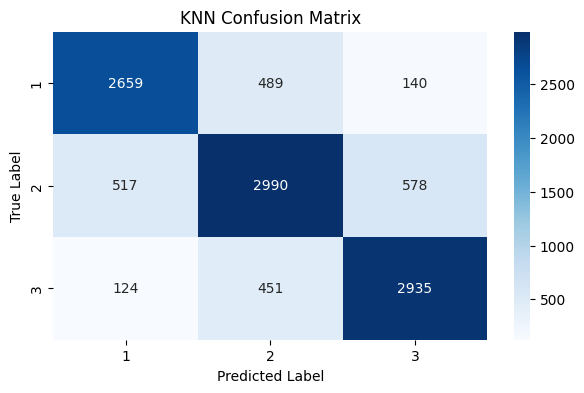

In [13]:
# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNN Confusion Matrix')
plt.show()

In [14]:
# Pipeline e GridSearchCV para RandomForest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

In [15]:
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_resampled, y_resampled)

# Avaliação do melhor modelo RandomForest
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("RandomForest Accuracy: ", accuracy_score(y_test, y_pred_rf))

RandomForest Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.86      0.87      3288
           2       0.83      0.82      0.82      4085
           3       0.88      0.90      0.89      3510

    accuracy                           0.86     10883
   macro avg       0.86      0.86      0.86     10883
weighted avg       0.86      0.86      0.86     10883

RandomForest Accuracy:  0.8587705595883488


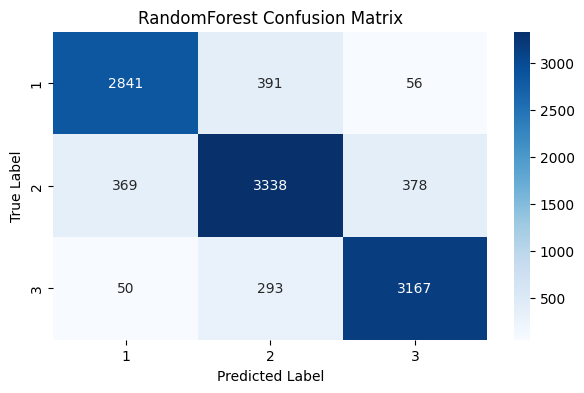

In [16]:
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RandomForest Confusion Matrix')
plt.show()

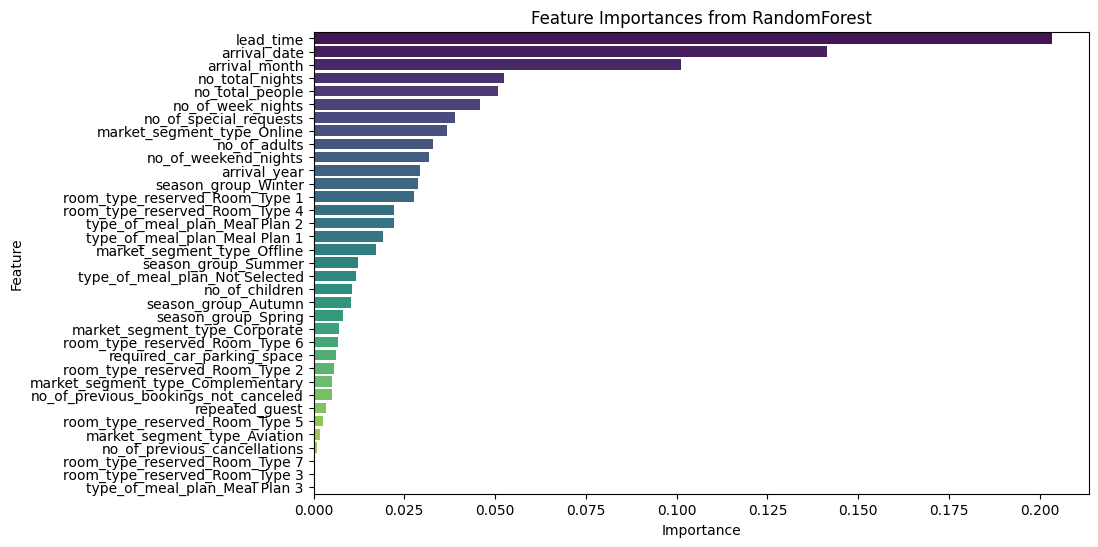

In [18]:
# Ajustar o pré-processador aos dados de treinamento para obter os nomes das características
preprocessor.fit(X_resampled)

# Feature Importances do RandomForest
importances = best_rf.named_steps['rf'].feature_importances_

# Obter nomes das características a partir do pré-processador
numeric_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features).tolist()
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_feature_names + categorical_feature_names

# Criar DataFrame com as importâncias das características
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Plotar as importâncias das características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')
plt.title('Feature Importances from RandomForest')
plt.show()
